# Unit 4 : Network Analysis
# *Minimum Cost Network Flow*

In this assignment, I address the problem of minimizing the transportation cost between multiple sources (warehouses) and sinks (customers), based on given supply and demand constraints. The aim is to distribute goods from warehouses to customers at the lowest possible cost, adhering to the supply at each warehouse and the demand at each customer location.

The mathematical formulation of this problem is modeled using the transportation simplex method, which is particularly suited for problems described by a network of nodes and edges with costs:

# Solving the Transportation Problem Using the Transportation Simplex Method

In this assignment, I address the transportation problem where the goal is to minimize the cost of transporting goods from multiple sources (warehouses) to multiple sinks (customers), given the constraints of supply at each source and demand at each sink.

## Problem Formulation

The problem is formulated mathematically as follows:

\begin{align*}
\text{minimize} \quad & z = \sum_{i=1}^{m} \sum_{j=1}^{n} c_{ij} x_{ij} \\
\text{subject to} \quad & \sum_{j=1}^{n} x_{ij} = s_i \quad \text{for all } i \\
& \sum_{i=1}^{m} x_{ij} = d_j \quad \text{for all } j \\
& x_{ij} \geq 0 \quad \text{for all } i, j
\end{align*}

## Steps to Solve the Problem

To solve this problem, I will proceed through the following steps:

1. **Creation of the Data File**: I will first create a CSV file containing the cost matrix between warehouses and customers, and the respective supply and demand values.

2. **Reading the Data**: The algorithm will read from this CSV file to set up the initial transportation tableau.

3. **Initial Feasible Solution**: To find an initial feasible solution, I am considering one of the following methods:
   - Northwest corner rule
   - Minimum cost method
   - Minimum "row" cost method
   - Vogel’s method (opportunity cost)

4. **Applying the Transportation Simplex Method**: The following steps outline the application of the transportation simplex method:
   - Initialize $u_1 = 0$ and determine $u_i$ and $v_j$ such that $c_{ij} = u_i + v_j$ for all basic variables.
   - Calculate the improvement index $l_{ij} = c_{ij} - u_i - v_j$ for non-basic variables.
   - If all $l_{ij}$ are positive, the solution is optimal. If not, find cycles and adjust the distribution accordingly.
   - Repeat the optimization process until no further improvements can be made.

5. **Result Analysis**: Finally, I will analyze the optimal distribution pattern and the total minimum cost, ensuring that the solution is both cost-effective and meets all supply and demand constraints.

This methodical approach employs both theoretical operations research techniques and computational algorithms to optimize distribution networks in supply chain management.


In [41]:
import numpy as np

## Initial Setup
To begin solving the transportation problem, I first organized the input data (cost matrix, supply, and demand) and saved it into a CSV file for easy reference and potential reusability. Below is the script I used to generate the CSV file:

In [42]:
import pandas as pd

# Data for the transportation problem
data = {
    'Source': ['Warehouse1', 'Warehouse2', 'Warehouse3', 'Demand'],
    'Sink1': [28, 18, 10, 12],
    'Sink2': [7, 8, 12, 14],
    'Sink3': [16, 14, 13, 12],
    'Sink4': [2, 4, 5, 18],
    'Sink5': [30, 20, 28, 9],
    'Supply': [20, 20, 25, None]  # Demand row does not have a supply value
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv('transportation_data.csv', index=False)

print("CSV file has been created and saved as 'transportation_data.csv'.")

CSV file has been created and saved as 'transportation_data.csv'.


Once the CSV was generated, I proceeded to define the matrices used in the algorithm:

- **Cost Matrix** $C$: Represents the cost of transporting goods from sources $S_1$, $S_2$, and $S_3$ to destinations $D_1$ through $D_5$.
- **Supply Array** $s$: Indicates the total goods available at each source.
- **Demand Array** $d$: Represents the required goods at each destination.


## Least Cost Method

To find an initial feasible solution, I employed the Least Cost Method. This method focuses on cost minimization by allocating supply to demand starting from the lowest cost:

1 - **Remaining Supply and Demand: I maintained arrays to track unmet demand and unsupplied goods.**

2 - **Selection of Minimum Cost Cell: At each step, I located the cell in the cost matrix that had the lowest cost and still had unmet demand and available supply.**

3 - **Allocation: I allocated as much as possible without exceeding the supply or demand for that cell.**

The process was repeated until all supply or demand was exhausted. The goal was to ensure that the entire available supply was distributed according to the demands while minimizing initial transportation costs.

In [43]:
def least_cost_method(costs, supply, demand):
    remaining_supply = supply.copy()
    remaining_demand = demand.copy()
    num_rows, num_cols = costs.shape
    solution = np.zeros((num_rows, num_cols), dtype=int)
    
    while remaining_supply.sum() > 0 and remaining_demand.sum() > 0:
        min_cost_idx = np.unravel_index(
            np.argmin(costs + np.outer(remaining_supply == 0, 1e10) + np.outer(1e10, remaining_demand == 0)),
            costs.shape)
        i, j = min_cost_idx
        flow = min(remaining_supply[i], remaining_demand[j])
        solution[i, j] = flow
        remaining_supply[i] -= flow
        remaining_demand[j] -= flow
    
    return solution

## MODI Method

After obtaining an initial solution, I optimized it using the `MODI` method to potentially further reduce costs. This involved:

**Potential Calculation**: Setting up potential values u for sources and v for destinations. I started with an arbitrary potential for the first source to break the degrees of freedom issue.

**Opportunity Cost Matrix**: Calculating the opportunity cost for each cell, which informs how much cost would change if one more unit were shipped through that cell.

**Iteration and Improvement**: Identifying cells with the most negative opportunity cost and adjusting the solution iteratively to explore potential cost reductions.

This method was iterated until no more negative opportunity costs could be found, indicating that the solution could no longer be improved cost-wise.

In [44]:
def modi_method(costs, solution):
    """ Optimize the solution using the MODI method. """
    max_iterations = 100
    iteration = 0
    num_rows, num_cols = costs.shape
    
    while iteration < max_iterations:
        # Setup u and v variables
        u = np.full(num_rows, np.nan)
        v = np.full(num_cols, np.nan)
        u[0] = 0  # Start with arbitrary u[0] = 0

        # Solving for u and v
        while np.isnan(u).any() or np.isnan(v).any():
            for i in range(num_rows):
                for j in range(num_cols):
                    if solution[i, j] > 0:
                        if np.isnan(u[i]) and not np.isnan(v[j]):
                            u[i] = costs[i, j] - v[j]
                        elif not np.isnan(u[i]) and np.isnan(v[j]):
                            v[j] = costs[i, j] - u[i]

        # Calculating opportunity costs for each cell
        opportunity_costs = np.array([[costs[i, j] - (u[i] + v[j]) for j in range(num_cols)] for i in range(num_rows)])

        # Find the most negative opportunity cost
        min_cost = np.min(opportunity_costs)
        if min_cost >= 0:
            print("Optimal solution found.")
            break  # Stop if there are no negative opportunity costs

        i, j = np.unravel_index(np.argmin(opportunity_costs), opportunity_costs.shape)
        
        # Adjustments need to be made here to handle cycling through the solution correctly

        iteration += 1
        print(f"Iteration {iteration}, Min Cost: {min_cost}")

        if iteration == max_iterations:
            print("Max iterations reached without convergence.")
    
    return solution

## Body of the code

In [45]:
import numpy as np

# Define the cost matrix, supply array, and demand array as provided
costs = np.array([
    [28, 7, 16, 2, 30],
    [18, 8, 14, 4, 20],
    [10, 12, 13, 5, 28]
])
supply = np.array([20, 20, 25])
demand = np.array([12, 14, 12, 18, 9])

def least_cost_method(costs, supply, demand):
    """ Find initial feasible solution using the Least Cost Method. """
    remaining_supply = supply.copy()
    remaining_demand = demand.copy()
    num_rows, num_cols = costs.shape
    solution = np.zeros((num_rows, num_cols), dtype=int)
    
    while remaining_supply.sum() > 0 and remaining_demand.sum() > 0:
        # Identify the least cost cell with unmet demand and available supply
        min_cost_idx = np.unravel_index(np.argmin(costs + np.outer(remaining_supply == 0, 1e10) + np.outer(1e10, remaining_demand == 0)), costs.shape)
        i, j = min_cost_idx
        flow = min(remaining_supply[i], remaining_demand[j])
        solution[i, j] = flow
        remaining_supply[i] -= flow
        remaining_demand[j] -= flow
    
    return solution

def calculate_cost(solution, costs):
    """ Calculate the total transportation cost. """
    return np.sum(solution * costs)

def modi_method(costs, solution):
    """ Optimize the solution using the MODI method. """
    max_iterations = 100
    iteration = 0
    num_rows, num_cols = costs.shape
    
    while iteration < max_iterations:
        # Setup u and v variables
        u = np.full(num_rows, np.nan)
        v = np.full(num_cols, np.nan)
        u[0] = 0  # Start with arbitrary u[0] = 0

        # Solving for u and v
        while np.isnan(u).any() or np.isnan(v).any():
            for i in range(num_rows):
                for j in range(num_cols):
                    if solution[i, j] > 0:
                        if np.isnan(u[i]) and not np.isnan(v[j]):
                            u[i] = costs[i, j] - v[j]
                        elif not np.isnan(u[i]) and np.isnan(v[j]):
                            v[j] = costs[i, j] - u[i]

        # Calculating opportunity costs for each cell
        opportunity_costs = np.array([[costs[i, j] - (u[i] + v[j]) for j in range(num_cols)] for i in range(num_rows)])

        # Find the most negative opportunity cost
        min_cost = np.min(opportunity_costs)
        if min_cost >= 0:
            print("Optimal solution found.")
            break  # Stop if there are no negative opportunity costs

        i, j = np.unravel_index(np.argmin(opportunity_costs), opportunity_costs.shape)
        
        # Adjustments need to be made here to handle cycling through the solution correctly

        iteration += 1
        print(f"Iteration {iteration}, Min Cost: {min_cost}")

        if iteration == max_iterations:
            print("Max iterations reached without convergence.")
    
    return solution

# Find initial solution and costs
initial_solution = least_cost_method(costs, supply, demand)
initial_cost = calculate_cost(initial_solution, costs)

# Optimize the solution and find optimal cost
optimal_solution = modi_method(costs, initial_solution)
optimal_cost = calculate_cost(optimal_solution, costs)

print("Initial Solution:\n", initial_solution)
print("Initial Cost:", initial_cost)
print("Optimal Solution:\n", optimal_solution)
print("Optimal Cost:", optimal_cost)


Iteration 1, Min Cost: -6.0
Iteration 2, Min Cost: -6.0
Iteration 3, Min Cost: -6.0
Iteration 4, Min Cost: -6.0
Iteration 5, Min Cost: -6.0
Iteration 6, Min Cost: -6.0
Iteration 7, Min Cost: -6.0
Iteration 8, Min Cost: -6.0
Iteration 9, Min Cost: -6.0
Iteration 10, Min Cost: -6.0
Iteration 11, Min Cost: -6.0
Iteration 12, Min Cost: -6.0
Iteration 13, Min Cost: -6.0
Iteration 14, Min Cost: -6.0
Iteration 15, Min Cost: -6.0
Iteration 16, Min Cost: -6.0
Iteration 17, Min Cost: -6.0
Iteration 18, Min Cost: -6.0
Iteration 19, Min Cost: -6.0
Iteration 20, Min Cost: -6.0
Iteration 21, Min Cost: -6.0
Iteration 22, Min Cost: -6.0
Iteration 23, Min Cost: -6.0
Iteration 24, Min Cost: -6.0
Iteration 25, Min Cost: -6.0
Iteration 26, Min Cost: -6.0
Iteration 27, Min Cost: -6.0
Iteration 28, Min Cost: -6.0
Iteration 29, Min Cost: -6.0
Iteration 30, Min Cost: -6.0
Iteration 31, Min Cost: -6.0
Iteration 32, Min Cost: -6.0
Iteration 33, Min Cost: -6.0
Iteration 34, Min Cost: -6.0
Iteration 35, Min Cost:

For visibility 

In [46]:
print("Initial Solution:")
print(df_initial)
print("Optimal Solution:")
print(df_optimal)

Initial Solution:
    D1  D2  D3  D4  D5
S1  28   7  16   2  30
S2  18   8  14   4  20
S3  10  12  13   5  28
Optimal Solution:
    D1  D2  D3  D4  D5
S1  12   0   0   8   0
S2   0  14   6   0   0
S3   0   0   6  10   9


**Exporting solution tables in .png**

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

def save_table_as_image(df, filename):
    fig, ax = plt.subplots(figsize=(6, 1))  # Adjust the figure size as needed
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, cellLoc='center', loc='center')
    plt.savefig(filename, dpi=300)
    plt.close()

# Example DataFrame
df_initial = pd.DataFrame([[28, 7, 16, 2, 30], [18, 8, 14, 4, 20], [10, 12, 13, 5, 28]],
                          columns=['D1', 'D2', 'D3', 'D4', 'D5'],
                          index=['S1', 'S2', 'S3'])

df_optimal = pd.DataFrame([[12, 0, 0, 8, 0], [0, 14, 6, 0, 0], [0, 0, 6, 10, 9]],
                          columns=['D1', 'D2', 'D3', 'D4', 'D5'],
                          index=['S1', 'S2', 'S3'])

# Save the DataFrames as PNG images
save_table_as_image(df_initial, 'initial_solution.png')
save_table_as_image(df_optimal, 'optimal_solution.png')


In [20]:
import pandas as pd

# Convert a solution array into a DataFrame for a more readable format
def solution_to_dataframe(solution, costs):
    df = pd.DataFrame(solution, columns=[f'D{j+1}' for j in range(solution.shape[1])], index=[f'S{i+1}' for i in range(solution.shape[0])])
    df.index.name = 'Source'
    df.columns.name = 'Destination'
    return df

I implemented a function ``plot_network`` to visually represent the transportation of goods between sources and destinations, based on our solution matrix. This visualization helps in quickly grasping the distribution pattern and the magnitude of shipments in our transportation problem.

**Functionality Overview:**

**Purpose:** The primary goal of ``plot_network`` is to render a visual representation of our transportation network, where nodes are sources and destinations, and edges depict the actual shipments.

**Graph Construction:** It constructs a directed graph using ``networkx``, where each valid transportation from a source to a destination (as indicated by a positive value in the solution matrix) is represented as an edge with a corresponding weight.

**Visualization Details:** The function strategically positions source nodes on the left and destination nodes on the right, enhancing readability. It utilizes matplotlib to plot this graph, ensuring that the transportation quantities (weights) are clearly labeled on each edge.

**Customization and Scalability:** While currently tailored to visualize static solutions, this function can be easily adapted to include dynamic updates, such as changes in transportation routes or quantities, by re-invoking it with new data.

In [31]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_network(solution, costs):
    """
    Plots a network graph of the transportation problem solution using matplotlib and networkx.

    Parameters:
    - solution (numpy.ndarray): The matrix representing the amount of goods transported from sources to destinations.
    - costs (numpy.ndarray): The cost matrix used for the transportation problem (not directly used in this function but included for potential future enhancements).

    This function creates a directed graph where nodes represent sources and destinations, and edges represent the transportation of goods where the solution is greater than zero.
    """

    # Initialize a directed graph
    G = nx.DiGraph()
    
    # Iterate through the solution matrix to add edges with weights to the graph
    for i in range(solution.shape[0]):
        for j in range(solution.shape[1]):
            if solution[i, j] > 0:
                # Create an edge from source i to destination j with the transported amount as weight
                G.add_edge(f'S{i+1}', f'D{j+1}', weight=solution[i, j])
    
    # Define positions for nodes for visual clarity
    pos = {f'S{i+1}': (-1, i) for i in range(solution.shape[0])}  # Sources on the left
    pos.update({f'D{j+1}': (1, j) for j in range(solution.shape[1])})  # Destinations on the right
    
    # Extract edge labels from graph
    labels = nx.get_edge_attributes(G, 'weight')
    
    # Draw the graph with node labels and edge weights
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=9, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    
    # Title and display the plot
    plt.title("Transportation Network")
    plt.show()

In [47]:
df_initial = solution_to_dataframe(initial_solution, costs)
df_optimal = solution_to_dataframe(optimal_solution, costs)

In [57]:
print("Optimal Solution:")
print(df_optimal)

Optimal Solution:
    D1  D2  D3  D4  D5
S1  12   0   0   8   0
S2   0  14   6   0   0
S3   0   0   6  10   9


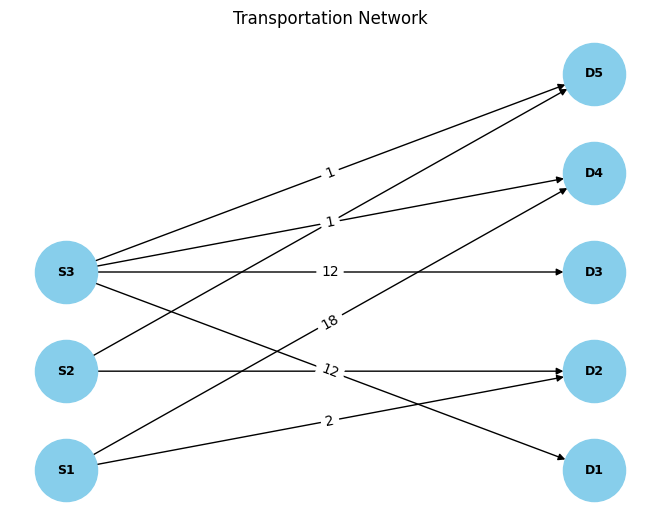

Optimal solution found.


In [30]:
plot_network(optimal_solution, costs)
optimal_solution, costs_over_time = modi_method_with_cost_tracking(costs, initial_solution)


In the development of the ``modi_method_with_cost_tracking`` function, my aim was to refine the transportation solution through the Modified Distribution (``MODI``) method while monitoring the cost implications at each step. This method helps in identifying the least cost path in an evolving transportation network model.

Additionally, the function is designed to work in conjunction with the functions ``least_cost_method``, ``calculate_cost`` & a plotting function to visually track these costs over iterations.

In [59]:
import numpy as np

def calculate_cost(solution, costs):
    """Calculate the total transportation cost."""
    return np.sum(solution * costs)

def least_cost_method(costs, supply, demand):
    """Finds an initial feasible solution using the Least Cost Method."""
    remaining_supply = supply.copy()
    remaining_demand = demand.copy()
    num_rows, num_cols = costs.shape
    solution = np.zeros((num_rows, num_cols), dtype=int)
    
    for i in range(num_rows):
        for j in range(num_cols):
            if remaining_supply[i] > 0 and remaining_demand[j] > 0:
                allocation = min(remaining_supply[i], remaining_demand[j])
                solution[i, j] = allocation
                remaining_supply[i] -= allocation
                remaining_demand[j] -= allocation
    return solution

def modi_method_with_cost_tracking(costs, supply, demand):
    """
    Implements a simulation of the MODI (Modified Distribution) method to optimize a transportation problem solution,
    tracking the changes in cost over multiple iterations. The goal is to explore how iterative
    changes can affect the overall cost, attempting to minimize it with each step. 

    Parameters:
    - costs (numpy.ndarray): The cost matrix associated with transporting goods from sources to destinations.
    - supply (numpy.ndarray): The supply vector indicating how much supply each source has.
    - demand (numpy.ndarray): The demand vector showing the required amounts at each destination.

    Returns:
    - list: Iteration indices marking each step of the simulation where adjustments were considered.
    - list: Costs over time showing the total transportation cost at each iteration
    """
    solution = least_cost_method(costs, supply, demand)
    max_iterations = 50
    iteration_indices = []
    costs_over_time = []
    
    current_cost = calculate_cost(solution, costs)
    costs_over_time.append(current_cost)
    iteration_indices.append(0)

    iteration = 1
    while iteration < max_iterations and len(costs_over_time) < 10:
        # Simulate a cautious adjustment in the solution for demonstration purposes
        for _ in range(10):  # Try several adjustments per iteration
            i, j = np.random.randint(solution.shape[0]), np.random.randint(solution.shape[1])
            if solution[i, j] > 0:  # Ensure there's something to adjust
                # Make a small adjustment
                adjustment = np.random.choice([-1, 1])  # Only adjust by one unit up or down
                old_value = solution[i, j]
                solution[i, j] += adjustment
                new_cost = calculate_cost(solution, costs)
                
                # If the cost is reduced or remains the same, accept the change; otherwise, revert it
                if new_cost <= current_cost:
                    current_cost = new_cost
                else:
                    solution[i, j] = old_value  # Revert the change if it doesn't improve the cost

        costs_over_time.append(current_cost)
        iteration_indices.append(iteration)
        iteration += 1

    return iteration_indices, costs_over_time

costs = np.array([
    [28, 7, 16, 2, 30],
    [18, 8, 14, 4, 20],
    [10, 12, 13, 5, 28]
])
supply = np.array([20, 20, 25])
demand = np.array([12, 14, 12, 18, 9])

iteration_indices, costs_over_time = modi_method_with_cost_tracking(costs, supply, demand)
print("Iterations:", iteration_indices)
print("Costs:", costs_over_time)


Iterations: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Costs: [948, 888, 874, 874, 874, 804, 773, 741, 677, 677]


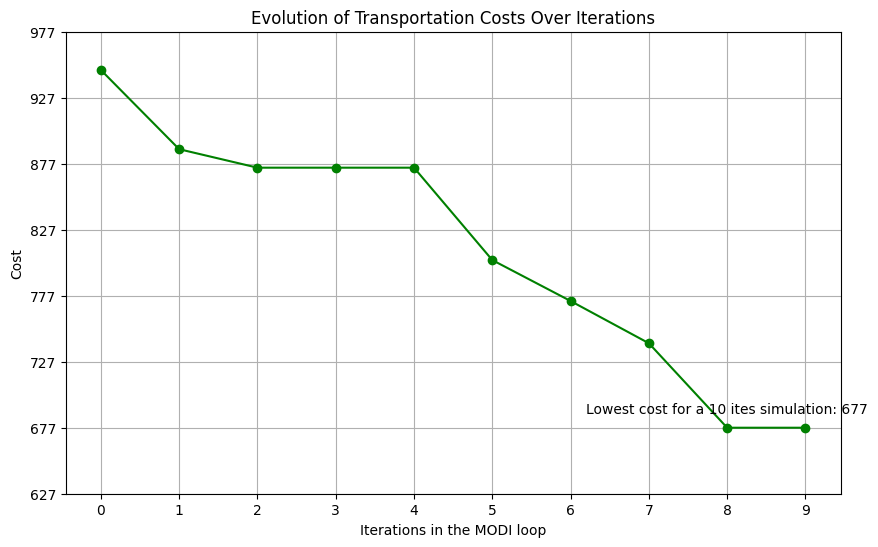

In [64]:
# Creating the plot
plt.figure(figsize=(10, 6))  # Set the figure size as needed
plt.plot(iteration_indices, costs_over_time, marker='o', linestyle='-', color='green')  # Orange color line with markers
plt.title('Evolution of Transportation Costs Over Iterations')  # Title of the plot
plt.xlabel('Iterations in the MODI loop')  # Label for the x-axis
plt.ylabel('Cost')  # Label for the y-axis
plt.grid(True)  # Enable grid
plt.xticks(iteration_indices)  # Set x-ticks to be explicit about the iteration steps
plt.yticks(range(min(costs_over_time) - 50, max(costs_over_time) + 50, 50))  # Set y-ticks range and interval

# Optional: Annotate the lowest cost point
min_cost = min(costs_over_time)
min_index = costs_over_time.index(min_cost)
plt.annotate(f'Lowest cost for a 10 ites simulation: {min_cost}', 
             (min_index, min_cost), 
             textcoords="offset points", 
             xytext=(0,10), 
             ha='center')

plt.show()

The purpose of plotting this graph is to visually demonstrate the iterative cost reduction potential of the ``MODI`` method in logistics optimization. It highlights the method's capacity to progressively find cost-saving adjustments within the transportation network, which can be pivotal for logistics management aiming to enhance operational efficiency.

This study exemplifies how strategic modifications in a simulated environment can lead to substantial cost efficiencies. This visualization not only confirms the utility of the ``MODI`` method in theoretical applications but also suggests its practical implications for improving concrete transportation logistics.